<a href="https://colab.research.google.com/github/sen-com/colaboratory/blob/main/GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**編集中**
# 事例研究08回


| 回次   | 曜日     | 内容               |
| ------ | -------- | ------------------ |
| 第2回  | 10月20日(火)5限 | 上級生研究内容発表(1/2) |
| 第3回  | 10月27日(火)5限 | 上級生研究内容発表(2/2) |
| 第4回  | 11月3日(火) 5限 | Deepラーニングは怖くない(CIFIR10編)|
| 第5回  | 11月10日(火)5限 | Deepラーニングは怖くない(CIFIR10編)2|
| --    | 11月17日(火) | 試験期間               |
| 第6回  | 11月24日(火)5限 | Alexさんによる人の声を対象にしたWave-net                    |
| 第7回  | 12月1日(火) 5限 | 竹田さんによる楽器音を対象にしたWave-net                   |
| **第8回**  | **12月8日(火) 5限**| **佐藤+上松によるDCGANは怖くない**|
| 第9回  | 12月15日(火) 5限| 選択課題提示　   |
| 第10回 | 12月22日(火) 5限| 各自選んだテーマの発表        |
| 休み | *20日間の休み* |                    |
| 第11回 | 1月12日(火)  5限| 進捗報告①                  |
| 第12回 | 1月19日(火)  5限| 進捗報告②      |

## 今後の流れ

第9回では先輩方がいろいろ動きそうなプログラムを調べてくれます\
それを皆さんが自身で選び動かすことになります

<動かすために>\
今日は最後に宿題を出します。

来週のプログラムを動かす時にも使うだけではなく、\
今後の研究を行う上で必要な力になりますので頑張ってみてください

参考サイト : [PyTorchでCIFAR-10を基にDCGANで画像生成をしてみよう ](https://www.atmarkit.co.jp/ait/articles/2011/27/news024.html)

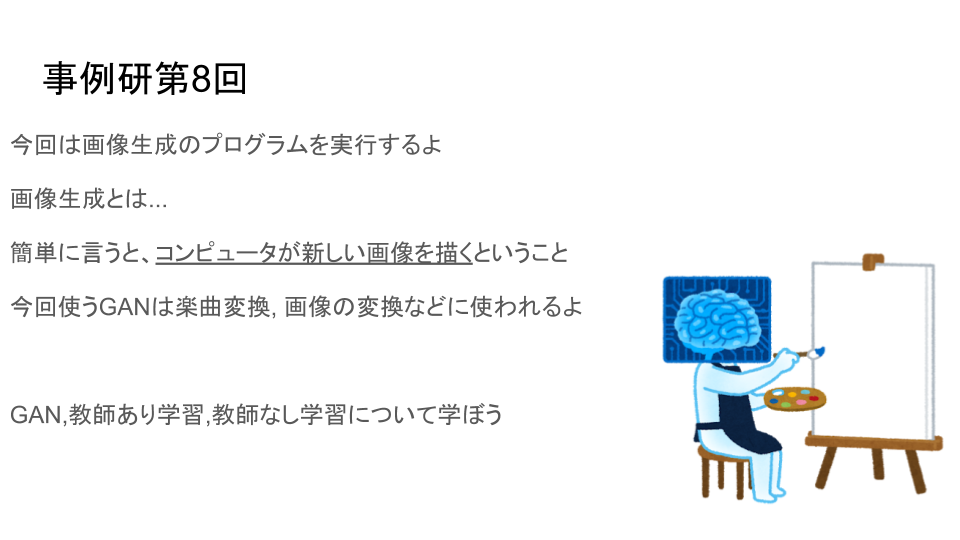

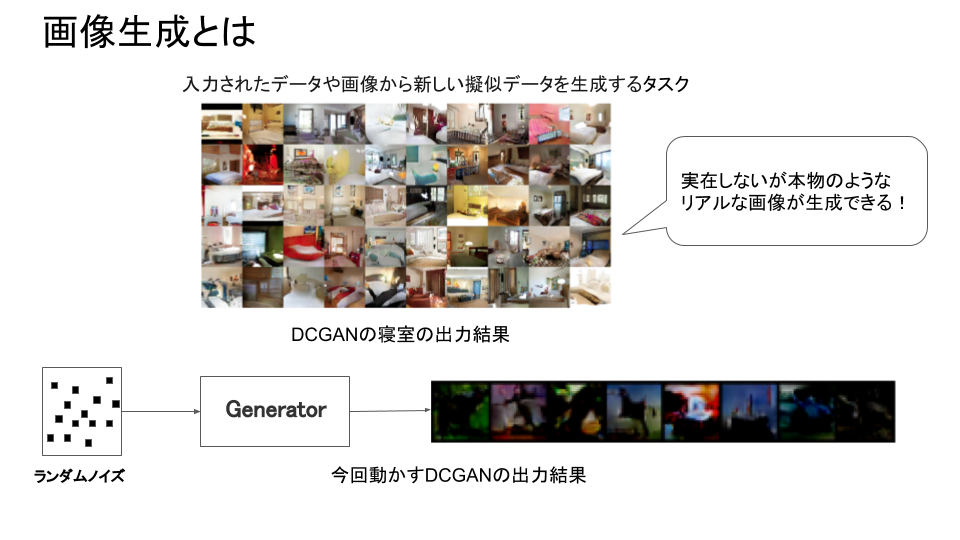

In [1]:
!nvidia-smi

Mon Dec 14 05:34:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### ライブラリインポート

In [2]:
#このセルはライブラリ(pytorch(機械学習ライブラリ),matplotlib(画像出力用),numpy(行列計算) )のimportをしている(佐藤コメント)
import torch
from torch import optim
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#このセルではdatasetのダウンロード(佐藤メモ)
'''
https://qiita.com/kazetof/items/6a72926b9f8cd44c218e
transformはデータの下処理(テンソルに変換)してtorchの型になるように処理をしている
（佐藤メモ）
Normalizeを変更してあげると、画像の処理が変わり画像の印象が変わるよ
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 100
trainset = CIFAR10('.', train=True, transform=transform, download=True)#trainデータをダウンロードしている(佐藤メモ)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)#trainデータをシャッフルしてbatch_sizeに切り分けたデータにする(佐藤メモ)

Files already downloaded and verified


In [4]:
# 学習中に生成された画像の表示、保存する関数
# 引数にepochを追加し、画像を上書きしないように変更した
def imshow(img, epoch):
    img = torchvision.utils.make_grid(img)
    npimg = img.detach().numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    
    #下のコメントアウトされている1行で画像を保存できるよ(毎度上書き保存になるから気を付けて)
    # epoch番号で保存
    plt.savefig(f'{epoch}.jpg')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


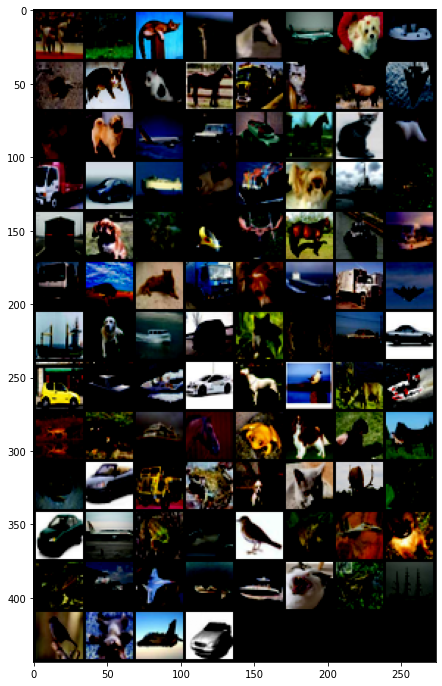

In [5]:
# 学習データをイテレータに変換
iterator = iter(trainloader)
img, _ = next(iterator)
print(img.shape)
imshow(img[0:100],1)

In [6]:
class MakeFrom(nn.Module):
    def __init__(self, s):
        super().__init__()
        self.model = s
    def forward(self, x):
        return self.model(x)

### 主要なモジュールの定義

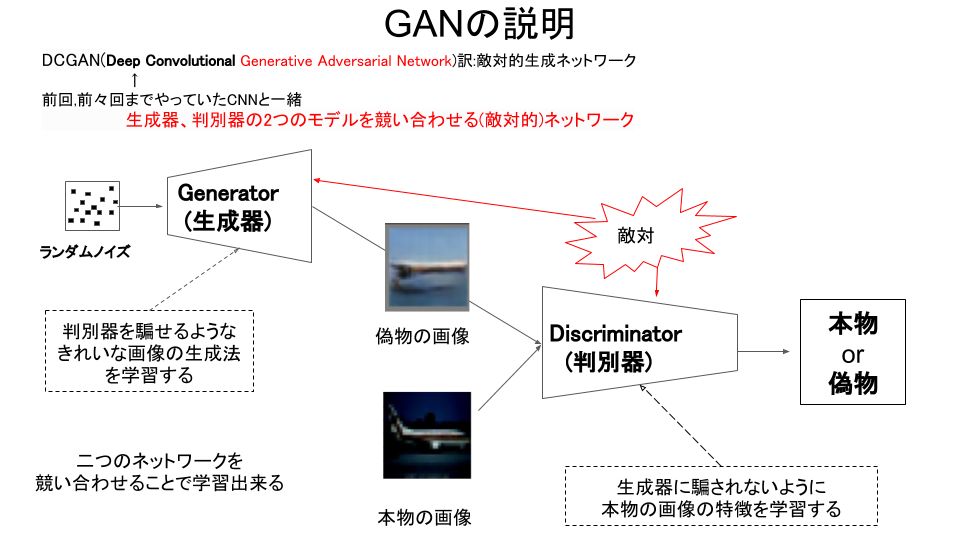

In [7]:
def train(netD, netG, batch_size, zsize, epochs, trainloader):
    losses_netD = []
    losses_netG = []
    out_D_real = []
    out_D_fake = []
    out_G = []

    # GPUを使用する準備
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    netD = netD.to(device)
    netG = netG.to(device)
    one_labels = torch.ones(batch_size).reshape(batch_size, 1).to(device)
    zero_labels = torch.zeros(batch_size).reshape(batch_size, 1).to(device)
    criterion = nn.BCELoss().to(device)

    optD = optim.Adam(netD.parameters(), lr=0.0002, betas=[0.5, 0.999])
    optG = optim.Adam(netG.parameters(), lr=0.0002, betas=[0.5, 0.999])

    # ノイズを固定
    fixed_noise = torch.randn(100, zsize, 1, 1).to(device)
    
    for epoch in range(1, epochs+1):
        running_loss_netD = 0.0
        running_loss_netG = 0.0
        for count, (real_imgs, _) in enumerate(trainloader, 1):
            netD.zero_grad()

            # 識別器の学習
            real_imgs = real_imgs.to(device)
            # データローダーから読み込んだデータを識別器に入力し、損失を計算
            output_real = netD(real_imgs).reshape(batch_size, -1)
            loss_real = criterion(output_real, one_labels)
            
            loss_real.backward()

            # 生成器から得たデータを、識別器に入力し、損失を計算
            z = torch.randn(batch_size, zsize, 1, 1).to(device)
            fake_imgs = netG(z).to(device)
            output_fake1 = netD(fake_imgs.detach()).reshape(batch_size, -1)
            loss_fake1 = criterion(output_fake1, zero_labels)
            loss_fake1.backward()

            # それらをまとめたものが最終的な損失
            loss_netD = loss_real + loss_fake1
            optD.step()
            running_loss_netD += loss_netD  # 1バッチ分の損失の平均値を加算

            # 生成器の学習
            netG.zero_grad()
            z = torch.randn(batch_size, zsize, 1, 1).to(device)
            fake_imgs = netG(z).to(device)
            output_fake2 = netD(fake_imgs).reshape(batch_size, -1)
            loss_netG = criterion(output_fake2, one_labels)
            loss_netG.backward()
            optG.step()
            running_loss_netG += loss_netG # 1バッチ分の損失の平均値を加算

            if epoch == 1:  # 最初のエポックだけ10、20、……、100バッチ終了時の学習状況を表示
                if count < 100 and count % 10 ==0:
                    stat1 = f'epoch: {epoch:02d}, batch: {count}\t'
                    stat2 = f'  lossD: {loss_netD:.4f}(real: {loss_real:.4f}, fake: {loss_fake1:.4f}),'
                    stat3 = f'lossG: {loss_netG:.4f},  D(x): {output_real.mean():.4f},'
                    stat4 = f'D(G(z)): {output_fake1.mean():.4f}, {output_fake2.mean():.4f}'
                    print(stat1, stat2, stat3, stat4)

            if count % 100 == 0:  # 1エポックの中で100回ごとに学習の状況を記録
                out_D_real.append(output_real.mean())
                out_D_fake.append(output_fake1.mean())
                out_G.append(output_fake2.mean())
                stat1 = f'epoch: {epoch:02d}, batch: {count}\t'
                stat2 = f'  lossD: {loss_netD:.4f}(real: {loss_real:.4f}, fake: {loss_fake1:.4f}),'
                stat3 = f'lossG: {loss_netG:.4f},  D(x): {output_real.mean():.4f},'
                stat4 = f'D(G(z)): {output_fake1.mean():.4f}, {output_fake2.mean():.4f}'
                print(stat1, stat2, stat3, stat4)
            
            

        running_loss_netD /= count  # 1エポック終了時にその間の損失の平均を求める
        running_loss_netG /= count
        losses_netD.append(running_loss_netD)
        losses_netG.append(running_loss_netG)
        print(f'epoch: {epoch}, running_loss_D: {running_loss_netD}, running_loss_G: {running_loss_netG}', '\n')

        # 20エポックごとに画像を生成
        if epoch % 20 == 0:
          generated_imgs = netG(fixed_noise[0:8]).cpu()
          imshow(generated_imgs.reshape(8, 3, 32, 32), epoch)
        
        if epoch % 50 == 0:
          plt.figure(figsize=(10,5))
          plt.title('losses')
          plt.plot(losses_netD, label='netD')
          plt.plot(losses_netG, label='netG')
          plt.xlabel('epoch')
          plt.ylabel('loss')
          plt.legend()
          plt.savefig(f'{epoch}_losses.jpg')
          plt.show()

          plt.figure(figsize=(10,5))
          plt.title('output from discriminator')
          plt.plot(out_D_real, label='D(x)')
          plt.plot(out_D_fake, label='D(G(z)) #1')
          plt.plot(out_G, label='D(G(z)) #2')
          plt.xlabel('x 100 batches')
          plt.ylabel('output')
          plt.legend()
          plt.savefig(f'{epoch}_output.jpg')
          plt.show()

    generated_imgs = netG(fixed_noise).cpu()
    imshow(generated_imgs.reshape(100, 3, 32, 32), 1821035)

    return (losses_netD, losses_netG), (out_D_real, out_D_fake, out_G), (netD, netG)

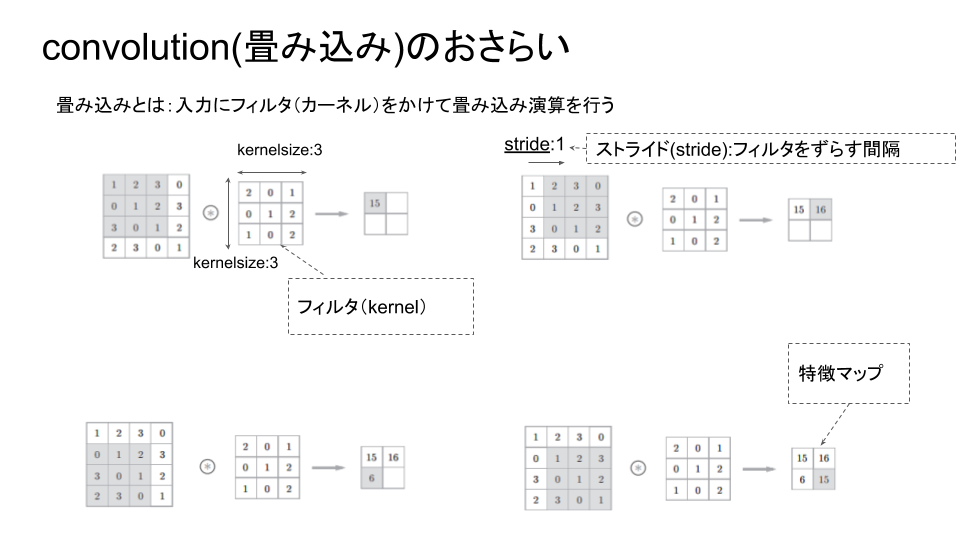

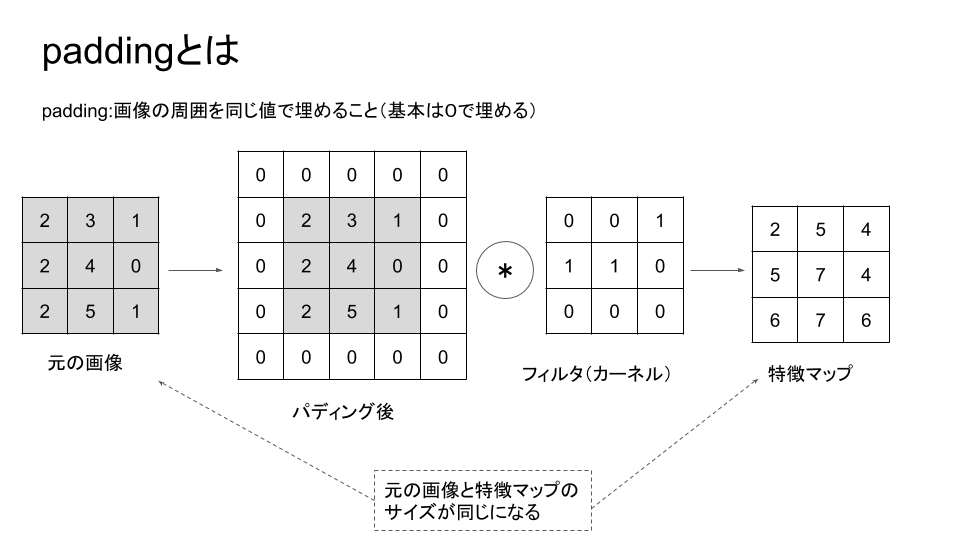

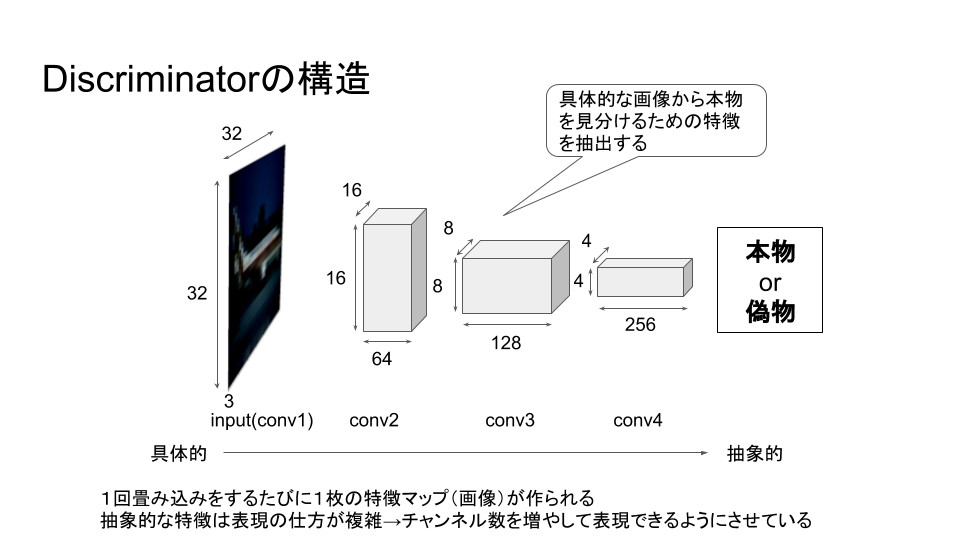

In [8]:
# 重みの初期値を変更する関数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# バッチ正規化を追加
discriminator = nn.Sequential(
    
    nn.Conv2d(3, 64, 4, 2, 1, bias=False), #input
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, 4, 2, 1, bias=False), #conv2
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, 4, 2, 1, bias=False), #conv3
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 1, 4, 1, 0, bias=False), #conv4
    nn.Sigmoid()
)

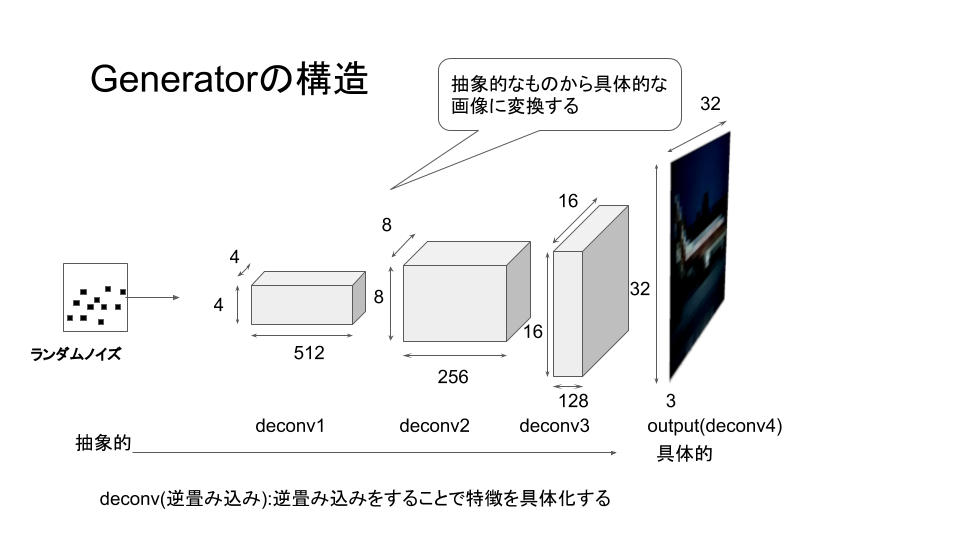

In [10]:
# バッチ正規化を追加
feature_maps = 64
zsize = 100
generator = nn.Sequential(
    nn.ConvTranspose2d(zsize, feature_maps * 8, 4, 1, 0, bias=False), #deconv1
    nn.BatchNorm2d(feature_maps * 8),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False), #deconv2
    nn.BatchNorm2d(feature_maps * 4),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False), #deconv3
    nn.BatchNorm2d(feature_maps * 2),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(feature_maps * 2, 3, 4, 2, 1, bias=False), #output
    nn.Tanh()
)

netD = MakeFrom(discriminator)
netG = MakeFrom(generator)

# 重みの平均を0、標準偏差を0.02に初期化
netD.apply(weights_init)
netG.apply(weights_init)

MakeFrom(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [11]:
iterator = iter(trainloader)
img, _ = next(iterator)

c1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
c2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
c3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
c4 = nn.Conv2d(256, 1, 4, 1, 0, bias=False)
b2 = nn.BatchNorm2d(128)
b3 = nn.BatchNorm2d(256)
relu = nn.LeakyReLU(0.2, inplace=True)
sigmoid = nn.Sigmoid()

x = relu(c1(img))
print(x.shape)
x = relu(b2(c2(x)))
print(x.shape)
x = relu(b3(c3(x)))
print(x.shape)
x = sigmoid(c4(x))
print(x.shape)

print('----')

zsize = 100
t1 = nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False)
bt1 = nn.BatchNorm2d(64 * 8)
t2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
bt2 = nn.BatchNorm2d(64 * 4)
t3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
bt3 = nn.BatchNorm2d(64 * 2)
t4 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1, bias=False)
tanh = nn.Tanh()

z = torch.randn(batch_size, zsize, 1, 1)
x = relu(bt1(t1(z)))
print(x.shape)
x = relu(bt2(t2(x)))
print(x.shape)
x = relu(bt3(t3(x)))
print(x.shape)
x = tanh(t4(x))
print(x.shape)

torch.Size([100, 64, 16, 16])
torch.Size([100, 128, 8, 8])
torch.Size([100, 256, 4, 4])
torch.Size([100, 1, 1, 1])
----
torch.Size([100, 512, 4, 4])
torch.Size([100, 256, 8, 8])
torch.Size([100, 128, 16, 16])
torch.Size([100, 3, 32, 32])


### GANの学習について

lossD:本物の画像を入れたときにどれくらい差があるか , 偽物の画像を入れたときにどれくらいの差があるか\
\
lossG:生成された画像が本物の画像とどれくらい差があるか\
\
D(x):discriminatorが本物と見抜いた割合（精度）\
\
D(G(z)):gen画像を入れたときの見抜いた割合、または騙された割合


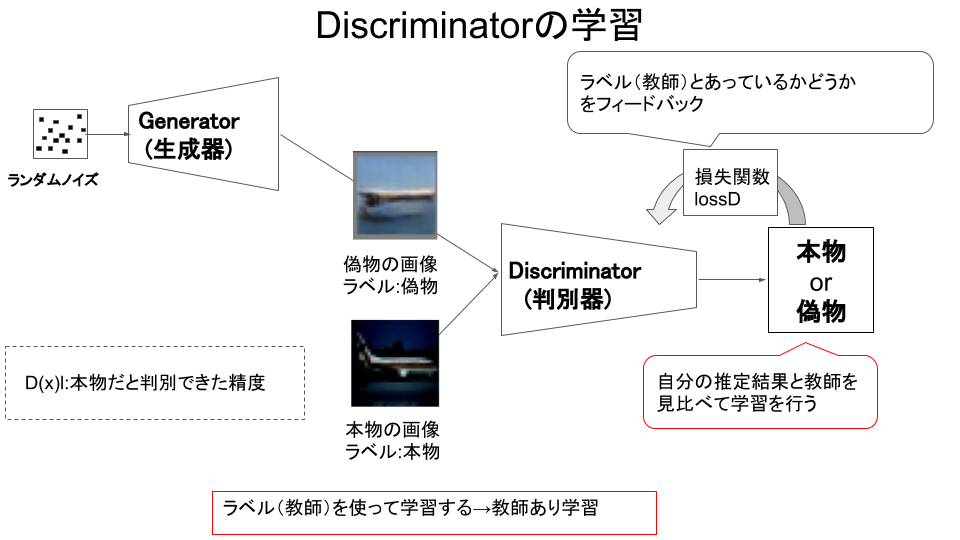

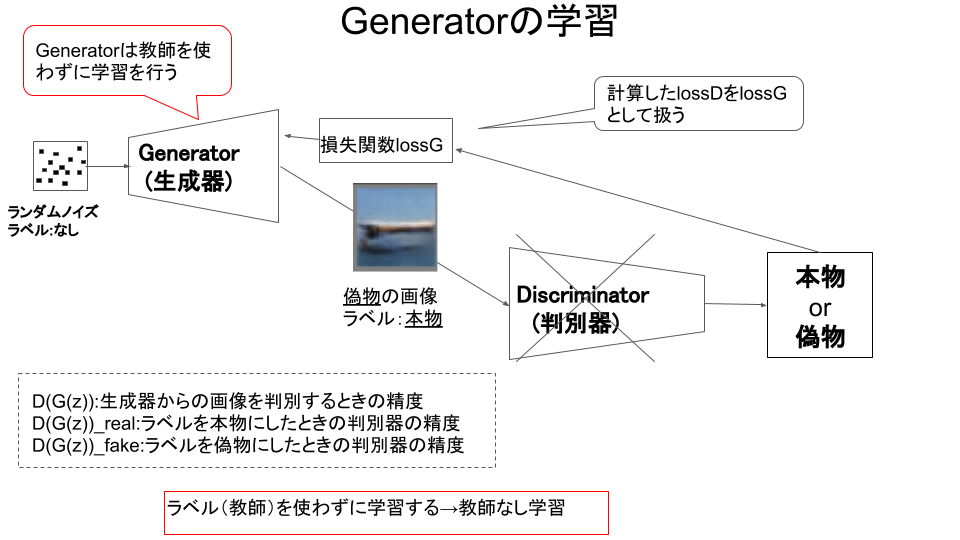

epoch: 01, batch: 10	   lossD: 1.3143(real: 0.6148, fake: 0.6995), lossG: 0.7033,  D(x): 0.5410, D(G(z)): 0.5032, 0.4950
epoch: 01, batch: 20	   lossD: 1.1536(real: 0.5289, fake: 0.6247), lossG: 0.8111,  D(x): 0.5898, D(G(z)): 0.4646, 0.4444
epoch: 01, batch: 30	   lossD: 0.8557(real: 0.3917, fake: 0.4640), lossG: 1.0455,  D(x): 0.6765, D(G(z)): 0.3712, 0.3515
epoch: 01, batch: 40	   lossD: 0.6064(real: 0.2805, fake: 0.3259), lossG: 1.3514,  D(x): 0.7558, D(G(z)): 0.2781, 0.2589
epoch: 01, batch: 50	   lossD: 0.4134(real: 0.1867, fake: 0.2267), lossG: 1.6728,  D(x): 0.8301, D(G(z)): 0.2029, 0.1877
epoch: 01, batch: 60	   lossD: 0.3293(real: 0.1485, fake: 0.1809), lossG: 1.9642,  D(x): 0.8628, D(G(z)): 0.1654, 0.1403
epoch: 01, batch: 70	   lossD: 0.2401(real: 0.1129, fake: 0.1272), lossG: 2.2458,  D(x): 0.8936, D(G(z)): 0.1195, 0.1059
epoch: 01, batch: 80	   lossD: 0.2103(real: 0.0918, fake: 0.1185), lossG: 2.3336,  D(x): 0.9126, D(G(z)): 0.1111, 0.1025
epoch: 01, batch: 90	   lossD: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20, batch: 500	   lossD: 1.0597(real: 0.1805, fake: 0.8792), lossG: 2.0358,  D(x): 0.8405, D(G(z)): 0.5603, 0.1581
epoch: 20, running_loss_D: 0.978803277015686, running_loss_G: 1.379848837852478 



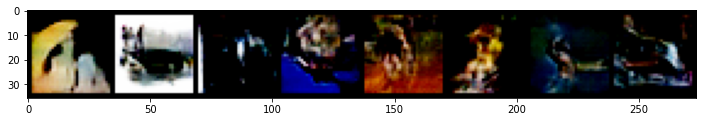

epoch: 21, batch: 100	   lossD: 0.8055(real: 0.4177, fake: 0.3878), lossG: 1.4664,  D(x): 0.6747, D(G(z)): 0.3052, 0.2661
epoch: 21, batch: 200	   lossD: 0.8149(real: 0.5484, fake: 0.2665), lossG: 0.9357,  D(x): 0.5970, D(G(z)): 0.2266, 0.4215
epoch: 21, batch: 300	   lossD: 0.9324(real: 0.5205, fake: 0.4119), lossG: 1.0789,  D(x): 0.6189, D(G(z)): 0.3220, 0.3699
epoch: 21, batch: 400	   lossD: 1.7237(real: 0.1199, fake: 1.6038), lossG: 2.9177,  D(x): 0.8906, D(G(z)): 0.7509, 0.0642
epoch: 21, batch: 500	   lossD: 0.8465(real: 0.5555, fake: 0.2910), lossG: 1.1912,  D(x): 0.5998, D(G(z)): 0.2370, 0.3321
epoch: 21, running_loss_D: 0.9603496789932251, running_loss_G: 1.408681869506836 

epoch: 22, batch: 100	   lossD: 0.9975(real: 0.5270, fake: 0.4706), lossG: 1.4820,  D(x): 0.6154, D(G(z)): 0.3541, 0.2518
epoch: 22, batch: 200	   lossD: 1.0805(real: 0.5914, fake: 0.4891), lossG: 1.1205,  D(x): 0.5828, D(G(z)): 0.3651, 0.3595
epoch: 22, batch: 300	   lossD: 0.8298(real: 0.2314, fake: 0.59

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 40, batch: 500	   lossD: 1.0560(real: 0.3883, fake: 0.6677), lossG: 1.2832,  D(x): 0.7073, D(G(z)): 0.4454, 0.3354
epoch: 40, running_loss_D: 0.8649742007255554, running_loss_G: 1.5983489751815796 



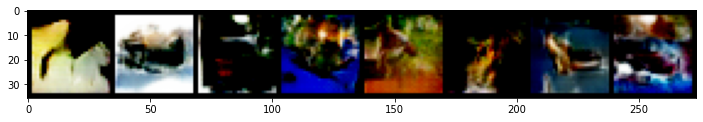

epoch: 41, batch: 100	   lossD: 0.7430(real: 0.2349, fake: 0.5081), lossG: 1.6317,  D(x): 0.8016, D(G(z)): 0.3648, 0.2263
epoch: 41, batch: 200	   lossD: 0.7274(real: 0.2296, fake: 0.4978), lossG: 1.5149,  D(x): 0.8082, D(G(z)): 0.3669, 0.2561
epoch: 41, batch: 300	   lossD: 0.7395(real: 0.4268, fake: 0.3127), lossG: 1.2815,  D(x): 0.6786, D(G(z)): 0.2533, 0.3277
epoch: 41, batch: 400	   lossD: 0.7496(real: 0.3999, fake: 0.3497), lossG: 1.2113,  D(x): 0.6878, D(G(z)): 0.2728, 0.3365
epoch: 41, batch: 500	   lossD: 1.2598(real: 0.0937, fake: 1.1661), lossG: 3.6251,  D(x): 0.9128, D(G(z)): 0.6461, 0.0395
epoch: 41, running_loss_D: 0.7856147289276123, running_loss_G: 1.6152116060256958 

epoch: 42, batch: 100	   lossD: 0.6730(real: 0.2521, fake: 0.4209), lossG: 1.4925,  D(x): 0.7872, D(G(z)): 0.3179, 0.2609
epoch: 42, batch: 200	   lossD: 0.8012(real: 0.2090, fake: 0.5923), lossG: 2.6574,  D(x): 0.8228, D(G(z)): 0.4194, 0.0913
epoch: 42, batch: 300	   lossD: 0.6786(real: 0.2096, fake: 0.4

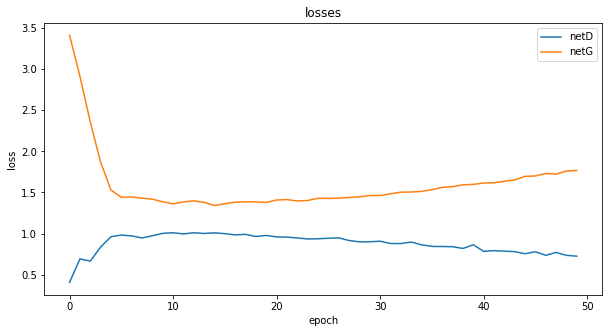

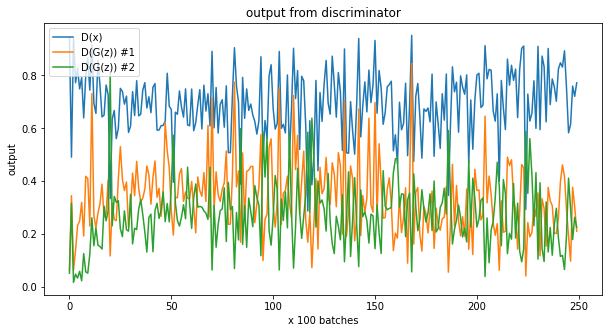

epoch: 51, batch: 100	   lossD: 0.6556(real: 0.4512, fake: 0.2044), lossG: 1.5213,  D(x): 0.6606, D(G(z)): 0.1735, 0.2722
epoch: 51, batch: 200	   lossD: 0.7818(real: 0.5890, fake: 0.1929), lossG: 0.7579,  D(x): 0.5893, D(G(z)): 0.1661, 0.5326
epoch: 51, batch: 300	   lossD: 0.7923(real: 0.6072, fake: 0.1851), lossG: 1.1328,  D(x): 0.5788, D(G(z)): 0.1569, 0.3728
epoch: 51, batch: 400	   lossD: 0.5051(real: 0.1002, fake: 0.4048), lossG: 2.4624,  D(x): 0.9075, D(G(z)): 0.3002, 0.1183
epoch: 51, batch: 500	   lossD: 0.6860(real: 0.2044, fake: 0.4815), lossG: 2.1124,  D(x): 0.8276, D(G(z)): 0.3531, 0.1566
epoch: 51, running_loss_D: 0.7456859946250916, running_loss_G: 1.7857866287231445 

epoch: 52, batch: 100	   lossD: 0.6255(real: 0.1808, fake: 0.4447), lossG: 2.5695,  D(x): 0.8441, D(G(z)): 0.3274, 0.1149
epoch: 52, batch: 200	   lossD: 0.7357(real: 0.4437, fake: 0.2919), lossG: 1.3529,  D(x): 0.6670, D(G(z)): 0.2345, 0.3353
epoch: 52, batch: 300	   lossD: 0.6960(real: 0.2375, fake: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 60, batch: 500	   lossD: 0.5498(real: 0.2582, fake: 0.2916), lossG: 2.6181,  D(x): 0.7877, D(G(z)): 0.2322, 0.1112
epoch: 60, running_loss_D: 0.654263973236084, running_loss_G: 1.9375823736190796 



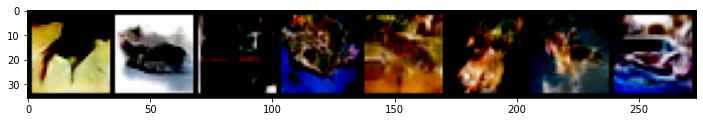

epoch: 61, batch: 100	   lossD: 0.4945(real: 0.3029, fake: 0.1916), lossG: 2.2331,  D(x): 0.7552, D(G(z)): 0.1634, 0.1564
epoch: 61, batch: 200	   lossD: 0.6460(real: 0.5603, fake: 0.0857), lossG: 1.7027,  D(x): 0.6066, D(G(z)): 0.0776, 0.2566
epoch: 61, batch: 300	   lossD: 0.9779(real: 0.8751, fake: 0.1028), lossG: 0.9176,  D(x): 0.4646, D(G(z)): 0.0947, 0.4638
epoch: 61, batch: 400	   lossD: 0.5078(real: 0.2674, fake: 0.2404), lossG: 2.1633,  D(x): 0.7844, D(G(z)): 0.1911, 0.1691
epoch: 61, batch: 500	   lossD: 0.7996(real: 0.5620, fake: 0.2376), lossG: 1.2341,  D(x): 0.6177, D(G(z)): 0.1956, 0.3469
epoch: 61, running_loss_D: 0.6549997925758362, running_loss_G: 1.9540036916732788 

epoch: 62, batch: 100	   lossD: 0.8602(real: 0.8194, fake: 0.0408), lossG: 1.4586,  D(x): 0.4994, D(G(z)): 0.0392, 0.3291
epoch: 62, batch: 200	   lossD: 0.7471(real: 0.0897, fake: 0.6575), lossG: 2.1289,  D(x): 0.9236, D(G(z)): 0.4345, 0.1710
epoch: 62, batch: 300	   lossD: 0.6679(real: 0.2189, fake: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 80, batch: 500	   lossD: 0.3173(real: 0.1619, fake: 0.1554), lossG: 2.8294,  D(x): 0.8619, D(G(z)): 0.1316, 0.0921
epoch: 80, running_loss_D: 0.48769038915634155, running_loss_G: 2.268576145172119 



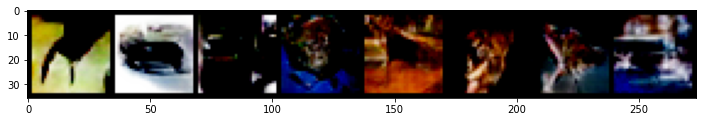

epoch: 81, batch: 100	   lossD: 0.4427(real: 0.3414, fake: 0.1013), lossG: 1.9194,  D(x): 0.7425, D(G(z)): 0.0913, 0.2118
epoch: 81, batch: 200	   lossD: 0.3842(real: 0.1456, fake: 0.2387), lossG: 3.1857,  D(x): 0.8714, D(G(z)): 0.1962, 0.0756
epoch: 81, batch: 300	   lossD: 0.7652(real: 0.1138, fake: 0.6513), lossG: 3.8083,  D(x): 0.8993, D(G(z)): 0.4225, 0.0398
epoch: 81, batch: 400	   lossD: 0.6081(real: 0.3737, fake: 0.2344), lossG: 1.6443,  D(x): 0.7178, D(G(z)): 0.1856, 0.2755
epoch: 81, batch: 500	   lossD: 0.5785(real: 0.0630, fake: 0.5155), lossG: 2.9347,  D(x): 0.9416, D(G(z)): 0.3520, 0.0861
epoch: 81, running_loss_D: 0.5646804571151733, running_loss_G: 2.3169498443603516 

epoch: 82, batch: 100	   lossD: 0.2573(real: 0.1160, fake: 0.1413), lossG: 2.5998,  D(x): 0.8949, D(G(z)): 0.1223, 0.1242
epoch: 82, batch: 200	   lossD: 0.3355(real: 0.1424, fake: 0.1932), lossG: 2.4065,  D(x): 0.8746, D(G(z)): 0.1575, 0.1493
epoch: 82, batch: 300	   lossD: 0.5931(real: 0.0875, fake: 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 100, batch: 500	   lossD: 0.4492(real: 0.3386, fake: 0.1106), lossG: 2.0588,  D(x): 0.7404, D(G(z)): 0.0979, 0.2043
epoch: 100, running_loss_D: 0.4700077474117279, running_loss_G: 2.584123134613037 



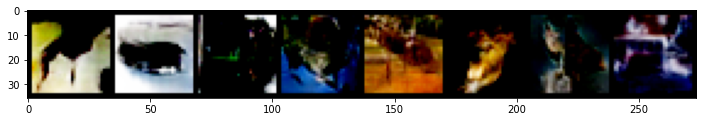

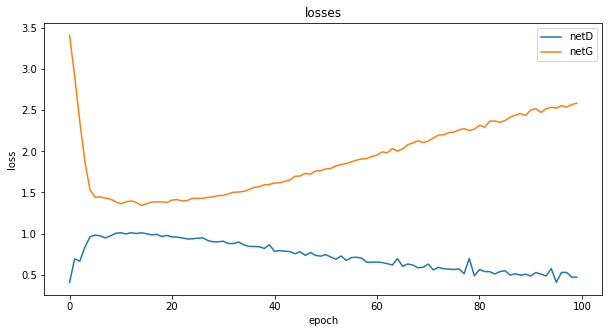

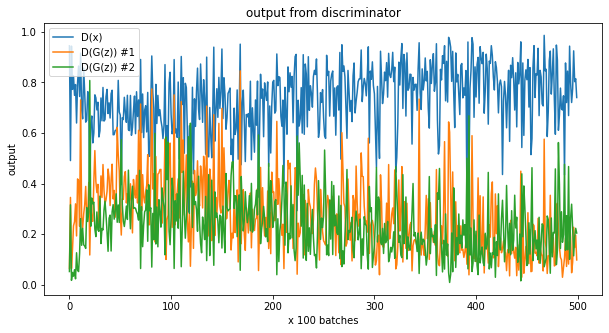

epoch: 101, batch: 100	   lossD: 0.3023(real: 0.0913, fake: 0.2110), lossG: 2.9756,  D(x): 0.9167, D(G(z)): 0.1752, 0.0946
epoch: 101, batch: 200	   lossD: 0.3231(real: 0.2119, fake: 0.1112), lossG: 2.0513,  D(x): 0.8270, D(G(z)): 0.0979, 0.2030
epoch: 101, batch: 300	   lossD: 0.3282(real: 0.1817, fake: 0.1465), lossG: 2.9400,  D(x): 0.8491, D(G(z)): 0.1235, 0.1047
epoch: 101, batch: 400	   lossD: 0.2780(real: 0.1650, fake: 0.1131), lossG: 2.2633,  D(x): 0.8589, D(G(z)): 0.0975, 0.1712
epoch: 101, batch: 500	   lossD: 1.8295(real: 1.7921, fake: 0.0374), lossG: 0.6703,  D(x): 0.2697, D(G(z)): 0.0310, 0.6176
epoch: 101, running_loss_D: 0.46915438771247864, running_loss_G: 2.614548444747925 

epoch: 102, batch: 100	   lossD: 0.3950(real: 0.2017, fake: 0.1933), lossG: 1.7285,  D(x): 0.8335, D(G(z)): 0.1552, 0.2712
epoch: 102, batch: 200	   lossD: 0.3145(real: 0.1797, fake: 0.1348), lossG: 2.3047,  D(x): 0.8450, D(G(z)): 0.1131, 0.1860
epoch: 102, batch: 300	   lossD: 0.2500(real: 0.1597, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 120, batch: 500	   lossD: 0.3763(real: 0.2692, fake: 0.1071), lossG: 2.3030,  D(x): 0.7934, D(G(z)): 0.0888, 0.1760
epoch: 120, running_loss_D: 0.49458548426628113, running_loss_G: 2.80856990814209 



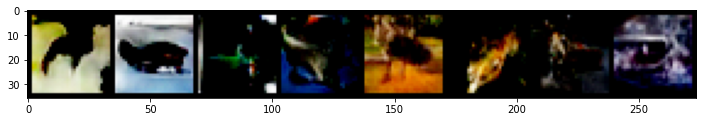

epoch: 121, batch: 100	   lossD: 0.2860(real: 0.1758, fake: 0.1101), lossG: 2.5956,  D(x): 0.8531, D(G(z)): 0.0985, 0.1188
epoch: 121, batch: 200	   lossD: 0.3102(real: 0.1772, fake: 0.1330), lossG: 2.1791,  D(x): 0.8546, D(G(z)): 0.1173, 0.1993
epoch: 121, batch: 300	   lossD: 0.4771(real: 0.3748, fake: 0.1022), lossG: 1.6485,  D(x): 0.7200, D(G(z)): 0.0913, 0.2822
epoch: 121, batch: 400	   lossD: 0.3445(real: 0.0194, fake: 0.3251), lossG: 2.7822,  D(x): 0.9811, D(G(z)): 0.2449, 0.1020
epoch: 121, batch: 500	   lossD: 0.2458(real: 0.0910, fake: 0.1548), lossG: 3.3510,  D(x): 0.9189, D(G(z)): 0.1270, 0.0756
epoch: 121, running_loss_D: 0.3978329300880432, running_loss_G: 2.7951440811157227 

epoch: 122, batch: 100	   lossD: 0.6451(real: 0.6213, fake: 0.0238), lossG: 1.7449,  D(x): 0.5915, D(G(z)): 0.0230, 0.2766
epoch: 122, batch: 200	   lossD: 0.2181(real: 0.1047, fake: 0.1133), lossG: 3.1370,  D(x): 0.9067, D(G(z)): 0.1001, 0.0900
epoch: 122, batch: 300	   lossD: 0.2623(real: 0.2112, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 140, batch: 500	   lossD: 0.3843(real: 0.3146, fake: 0.0697), lossG: 2.2220,  D(x): 0.7635, D(G(z)): 0.0618, 0.1984
epoch: 140, running_loss_D: 0.5031494498252869, running_loss_G: 3.022891044616699 



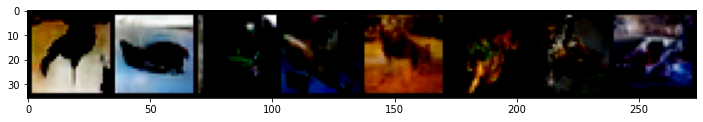

epoch: 141, batch: 100	   lossD: 0.2250(real: 0.1087, fake: 0.1162), lossG: 3.0811,  D(x): 0.9027, D(G(z)): 0.0988, 0.0885
epoch: 141, batch: 200	   lossD: 0.4342(real: 0.0892, fake: 0.3450), lossG: 3.9105,  D(x): 0.9201, D(G(z)): 0.2558, 0.0442
epoch: 141, batch: 300	   lossD: 0.2775(real: 0.0599, fake: 0.2176), lossG: 2.4946,  D(x): 0.9456, D(G(z)): 0.1729, 0.1562
epoch: 141, batch: 400	   lossD: 0.4292(real: 0.0956, fake: 0.3336), lossG: 3.8973,  D(x): 0.9138, D(G(z)): 0.2491, 0.0614
epoch: 141, batch: 500	   lossD: 0.2563(real: 0.1506, fake: 0.1057), lossG: 2.7272,  D(x): 0.8705, D(G(z)): 0.0925, 0.1223
epoch: 141, running_loss_D: 0.3849516808986664, running_loss_G: 3.0063207149505615 

epoch: 142, batch: 100	   lossD: 0.2738(real: 0.0957, fake: 0.1782), lossG: 3.3110,  D(x): 0.9154, D(G(z)): 0.1318, 0.0735
epoch: 142, batch: 200	   lossD: 0.3249(real: 0.0843, fake: 0.2406), lossG: 3.1808,  D(x): 0.9238, D(G(z)): 0.1717, 0.0858
epoch: 142, batch: 300	   lossD: 0.2697(real: 0.1265, 

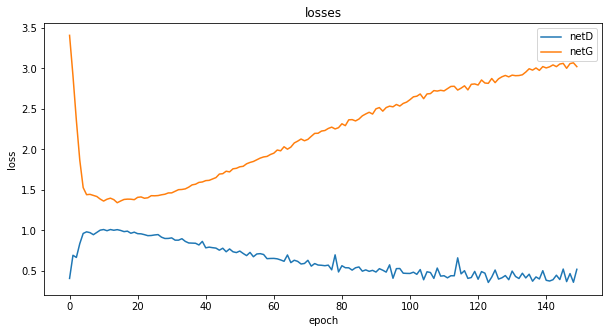

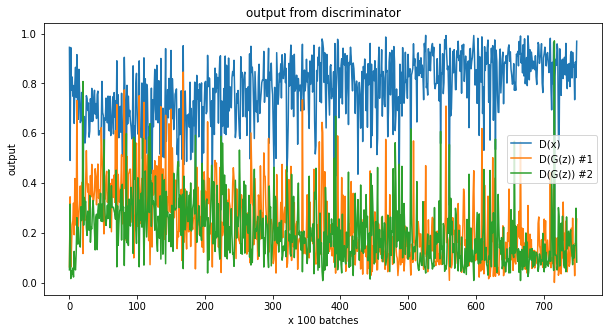

epoch: 151, batch: 100	   lossD: 0.6875(real: 0.5822, fake: 0.1053), lossG: 1.2976,  D(x): 0.6179, D(G(z)): 0.0846, 0.4401
epoch: 151, batch: 200	   lossD: 0.4664(real: 0.3851, fake: 0.0813), lossG: 1.6184,  D(x): 0.7188, D(G(z)): 0.0673, 0.3267
epoch: 151, batch: 300	   lossD: 0.2968(real: 0.1109, fake: 0.1859), lossG: 3.8734,  D(x): 0.9078, D(G(z)): 0.1340, 0.0488
epoch: 151, batch: 400	   lossD: 0.4903(real: 0.1659, fake: 0.3244), lossG: 3.1861,  D(x): 0.8593, D(G(z)): 0.2337, 0.0988
epoch: 151, batch: 500	   lossD: 0.6816(real: 0.0953, fake: 0.5863), lossG: 3.9270,  D(x): 0.9170, D(G(z)): 0.3489, 0.0551
epoch: 151, running_loss_D: 0.434186726808548, running_loss_G: 3.0342278480529785 

epoch: 152, batch: 100	   lossD: 0.4402(real: 0.3580, fake: 0.0822), lossG: 1.4438,  D(x): 0.7409, D(G(z)): 0.0735, 0.3903
epoch: 152, batch: 200	   lossD: 0.2618(real: 0.0898, fake: 0.1719), lossG: 2.7958,  D(x): 0.9238, D(G(z)): 0.1357, 0.1220
epoch: 152, batch: 300	   lossD: 0.3025(real: 0.2085, f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 160, batch: 500	   lossD: 0.3035(real: 0.2508, fake: 0.0527), lossG: 3.0272,  D(x): 0.8089, D(G(z)): 0.0489, 0.1445
epoch: 160, running_loss_D: 0.4897097945213318, running_loss_G: 3.1004602909088135 



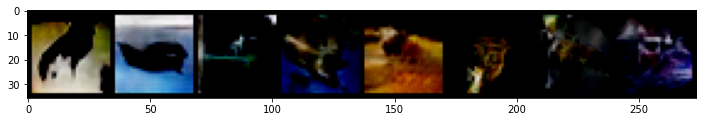

epoch: 161, batch: 100	   lossD: 0.3091(real: 0.2678, fake: 0.0413), lossG: 1.7152,  D(x): 0.7920, D(G(z)): 0.0389, 0.2779
epoch: 161, batch: 200	   lossD: 0.3067(real: 0.2097, fake: 0.0970), lossG: 3.0645,  D(x): 0.8298, D(G(z)): 0.0825, 0.1094
epoch: 161, batch: 300	   lossD: 0.1265(real: 0.0814, fake: 0.0451), lossG: 3.1356,  D(x): 0.9264, D(G(z)): 0.0421, 0.0932
epoch: 161, batch: 400	   lossD: 0.3818(real: 0.2265, fake: 0.1553), lossG: 3.2068,  D(x): 0.8258, D(G(z)): 0.1291, 0.0905
epoch: 161, batch: 500	   lossD: 0.5292(real: 0.0575, fake: 0.4717), lossG: 3.2109,  D(x): 0.9481, D(G(z)): 0.2933, 0.0846
epoch: 161, running_loss_D: 0.37514519691467285, running_loss_G: 3.069955348968506 

epoch: 162, batch: 100	   lossD: 0.3523(real: 0.0315, fake: 0.3209), lossG: 3.6130,  D(x): 0.9701, D(G(z)): 0.2385, 0.0585
epoch: 162, batch: 200	   lossD: 0.3014(real: 0.2208, fake: 0.0806), lossG: 2.3344,  D(x): 0.8192, D(G(z)): 0.0707, 0.2167
epoch: 162, batch: 300	   lossD: 0.2347(real: 0.1294, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 180, batch: 500	   lossD: 1.0528(real: 0.0070, fake: 1.0458), lossG: 4.7611,  D(x): 0.9930, D(G(z)): 0.5240, 0.0277
epoch: 180, running_loss_D: 0.38536256551742554, running_loss_G: 3.220428228378296 



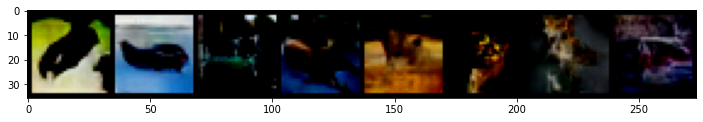

epoch: 181, batch: 100	   lossD: 0.2071(real: 0.0533, fake: 0.1538), lossG: 2.7099,  D(x): 0.9503, D(G(z)): 0.1295, 0.1236
epoch: 181, batch: 200	   lossD: 0.3281(real: 0.0526, fake: 0.2755), lossG: 3.6234,  D(x): 0.9548, D(G(z)): 0.1887, 0.0600
epoch: 181, batch: 300	   lossD: 0.5138(real: 0.4783, fake: 0.0355), lossG: 1.7613,  D(x): 0.6638, D(G(z)): 0.0333, 0.3030
epoch: 181, batch: 400	   lossD: 0.2992(real: 0.0756, fake: 0.2236), lossG: 4.1013,  D(x): 0.9319, D(G(z)): 0.1747, 0.0427
epoch: 181, batch: 500	   lossD: 0.6112(real: 0.5354, fake: 0.0758), lossG: 2.7981,  D(x): 0.6669, D(G(z)): 0.0666, 0.1609
epoch: 181, running_loss_D: 0.3860466480255127, running_loss_G: 3.2328288555145264 

epoch: 182, batch: 100	   lossD: 0.2291(real: 0.1394, fake: 0.0897), lossG: 2.4276,  D(x): 0.8868, D(G(z)): 0.0803, 0.1712
epoch: 182, batch: 200	   lossD: 0.3164(real: 0.0910, fake: 0.2253), lossG: 4.3332,  D(x): 0.9223, D(G(z)): 0.1814, 0.0357
epoch: 182, batch: 300	   lossD: 0.5176(real: 0.0633, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 200, batch: 500	   lossD: 0.3075(real: 0.1809, fake: 0.1265), lossG: 2.8384,  D(x): 0.8490, D(G(z)): 0.1045, 0.1487
epoch: 200, running_loss_D: 0.3474539518356323, running_loss_G: 3.3111867904663086 



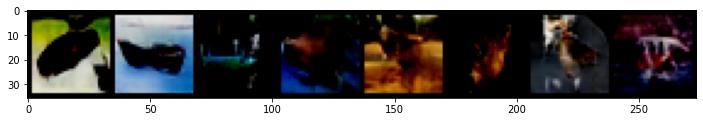

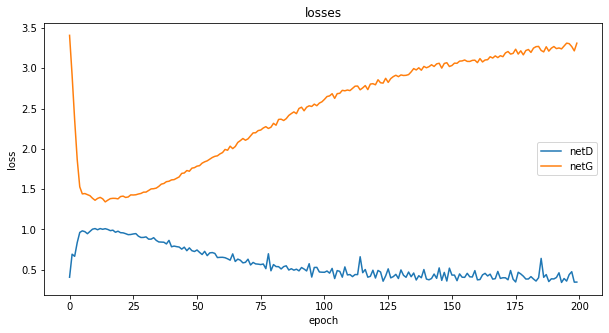

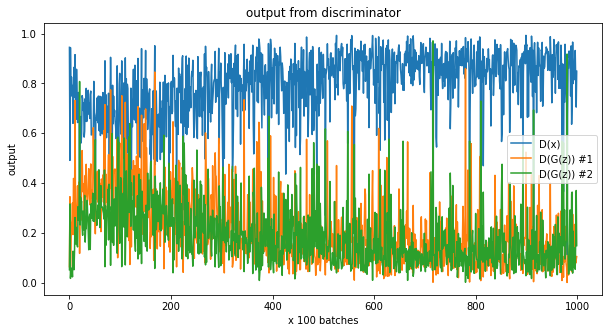

epoch: 201, batch: 100	   lossD: 0.3009(real: 0.2307, fake: 0.0702), lossG: 2.5331,  D(x): 0.8168, D(G(z)): 0.0534, 0.1811
epoch: 201, batch: 200	   lossD: 0.5019(real: 0.2224, fake: 0.2795), lossG: 3.6427,  D(x): 0.8353, D(G(z)): 0.1921, 0.0747
epoch: 201, batch: 300	   lossD: 0.2327(real: 0.0709, fake: 0.1618), lossG: 2.9689,  D(x): 0.9377, D(G(z)): 0.1203, 0.1292
epoch: 201, batch: 400	   lossD: 0.3919(real: 0.0614, fake: 0.3305), lossG: 4.6059,  D(x): 0.9482, D(G(z)): 0.2317, 0.0308
epoch: 201, batch: 500	   lossD: 0.4511(real: 0.2371, fake: 0.2140), lossG: 2.2803,  D(x): 0.8208, D(G(z)): 0.1552, 0.2106
epoch: 201, running_loss_D: 0.369307279586792, running_loss_G: 3.3554270267486572 

epoch: 202, batch: 100	   lossD: 0.2447(real: 0.2220, fake: 0.0227), lossG: 3.1579,  D(x): 0.8209, D(G(z)): 0.0219, 0.0950
epoch: 202, batch: 200	   lossD: 0.4147(real: 0.4015, fake: 0.0133), lossG: 2.7434,  D(x): 0.7190, D(G(z)): 0.0129, 0.1655
epoch: 202, batch: 300	   lossD: 0.3481(real: 0.1056, f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 220, batch: 500	   lossD: 0.4346(real: 0.0802, fake: 0.3544), lossG: 3.9383,  D(x): 0.9298, D(G(z)): 0.2333, 0.0627
epoch: 220, running_loss_D: 0.4404262900352478, running_loss_G: 3.414001941680908 



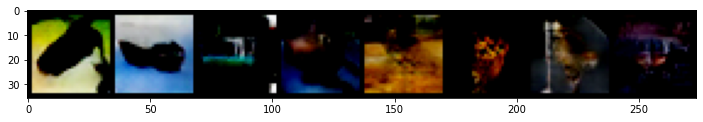

epoch: 221, batch: 100	   lossD: 0.3046(real: 0.0709, fake: 0.2338), lossG: 4.3929,  D(x): 0.9372, D(G(z)): 0.1733, 0.0413
epoch: 221, batch: 200	   lossD: 0.3003(real: 0.0910, fake: 0.2093), lossG: 4.0264,  D(x): 0.9191, D(G(z)): 0.1508, 0.0536
epoch: 221, batch: 300	   lossD: 0.4521(real: 0.0105, fake: 0.4416), lossG: 2.2948,  D(x): 0.9897, D(G(z)): 0.2894, 0.2313
epoch: 221, batch: 400	   lossD: 0.4534(real: 0.3960, fake: 0.0574), lossG: 1.5125,  D(x): 0.7182, D(G(z)): 0.0533, 0.3404
epoch: 221, batch: 500	   lossD: 0.1736(real: 0.1212, fake: 0.0523), lossG: 3.2576,  D(x): 0.8997, D(G(z)): 0.0449, 0.0882
epoch: 221, running_loss_D: 0.36274614930152893, running_loss_G: 3.4964840412139893 

epoch: 222, batch: 100	   lossD: 0.3950(real: 0.3406, fake: 0.0545), lossG: 2.1754,  D(x): 0.7527, D(G(z)): 0.0483, 0.2245
epoch: 222, batch: 200	   lossD: 0.2507(real: 0.1786, fake: 0.0720), lossG: 2.8454,  D(x): 0.8524, D(G(z)): 0.0642, 0.1688
epoch: 222, batch: 300	   lossD: 1.2015(real: 0.0062,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 240, batch: 500	   lossD: 0.4427(real: 0.0436, fake: 0.3991), lossG: 4.4033,  D(x): 0.9664, D(G(z)): 0.2614, 0.0498
epoch: 240, running_loss_D: 0.37547218799591064, running_loss_G: 3.604363203048706 



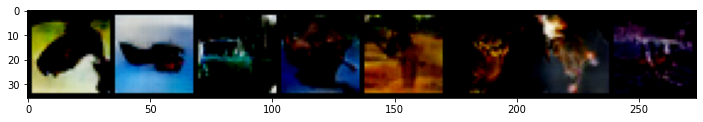

epoch: 241, batch: 100	   lossD: 0.1418(real: 0.0483, fake: 0.0935), lossG: 4.5061,  D(x): 0.9551, D(G(z)): 0.0760, 0.0397
epoch: 241, batch: 200	   lossD: 0.3387(real: 0.0677, fake: 0.2711), lossG: 2.8814,  D(x): 0.9395, D(G(z)): 0.1886, 0.1167
epoch: 241, batch: 300	   lossD: 1.0083(real: 0.0048, fake: 1.0034), lossG: 6.6494,  D(x): 0.9952, D(G(z)): 0.4912, 0.0092
epoch: 241, batch: 400	   lossD: 0.5738(real: 0.2963, fake: 0.2775), lossG: 2.0967,  D(x): 0.8218, D(G(z)): 0.1978, 0.2876
epoch: 241, batch: 500	   lossD: 0.4013(real: 0.3209, fake: 0.0804), lossG: 2.1134,  D(x): 0.7692, D(G(z)): 0.0681, 0.2742
epoch: 241, running_loss_D: 0.3565523326396942, running_loss_G: 3.5973358154296875 

epoch: 242, batch: 100	   lossD: 0.2677(real: 0.1399, fake: 0.1278), lossG: 3.3472,  D(x): 0.8853, D(G(z)): 0.1067, 0.0985
epoch: 242, batch: 200	   lossD: 0.1778(real: 0.1324, fake: 0.0454), lossG: 2.1741,  D(x): 0.8872, D(G(z)): 0.0344, 0.2376
epoch: 242, batch: 300	   lossD: 0.1390(real: 0.0825, 

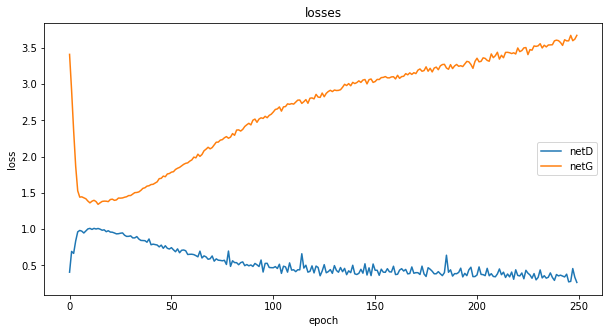

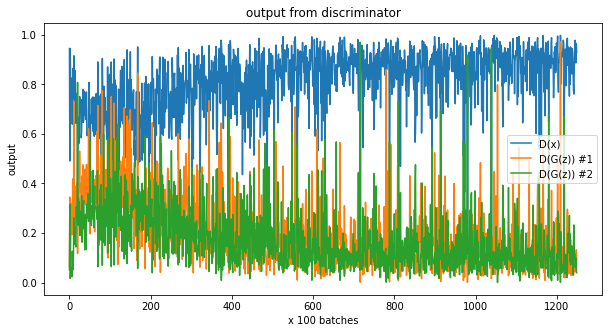

epoch: 251, batch: 100	   lossD: 0.2102(real: 0.0671, fake: 0.1431), lossG: 4.6709,  D(x): 0.9396, D(G(z)): 0.1163, 0.0339
epoch: 251, batch: 200	   lossD: 0.1404(real: 0.1111, fake: 0.0293), lossG: 3.4695,  D(x): 0.9059, D(G(z)): 0.0277, 0.1220
epoch: 251, batch: 300	   lossD: 0.3043(real: 0.0110, fake: 0.2933), lossG: 4.0979,  D(x): 0.9891, D(G(z)): 0.2093, 0.0615
epoch: 251, batch: 400	   lossD: 0.3609(real: 0.1583, fake: 0.2026), lossG: 3.6085,  D(x): 0.8723, D(G(z)): 0.1601, 0.0847
epoch: 251, batch: 500	   lossD: 0.3286(real: 0.0356, fake: 0.2930), lossG: 4.6108,  D(x): 0.9687, D(G(z)): 0.2106, 0.0440
epoch: 251, running_loss_D: 0.4277375340461731, running_loss_G: 3.5491104125976562 

epoch: 252, batch: 100	   lossD: 0.1977(real: 0.1716, fake: 0.0261), lossG: 4.2538,  D(x): 0.8611, D(G(z)): 0.0234, 0.0621
epoch: 252, batch: 200	   lossD: 0.1668(real: 0.0691, fake: 0.0978), lossG: 3.2938,  D(x): 0.9376, D(G(z)): 0.0785, 0.0984
epoch: 252, batch: 300	   lossD: 0.2879(real: 0.0622, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 260, batch: 500	   lossD: 0.2424(real: 0.0900, fake: 0.1525), lossG: 3.2272,  D(x): 0.9225, D(G(z)): 0.1152, 0.0947
epoch: 260, running_loss_D: 0.4199777841567993, running_loss_G: 3.6972055435180664 



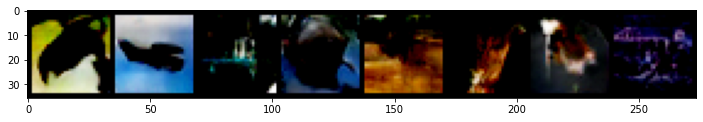

epoch: 261, batch: 100	   lossD: 0.2097(real: 0.0667, fake: 0.1430), lossG: 3.8874,  D(x): 0.9387, D(G(z)): 0.1086, 0.0697
epoch: 261, batch: 200	   lossD: 0.2150(real: 0.0521, fake: 0.1629), lossG: 3.2299,  D(x): 0.9516, D(G(z)): 0.1356, 0.1120
epoch: 261, batch: 300	   lossD: 0.1967(real: 0.0598, fake: 0.1369), lossG: 4.2579,  D(x): 0.9455, D(G(z)): 0.1070, 0.0452
epoch: 261, batch: 400	   lossD: 0.2235(real: 0.0343, fake: 0.1893), lossG: 3.5413,  D(x): 0.9687, D(G(z)): 0.1486, 0.1078
epoch: 261, batch: 500	   lossD: 0.2347(real: 0.1550, fake: 0.0797), lossG: 2.7620,  D(x): 0.8733, D(G(z)): 0.0663, 0.1596
epoch: 261, running_loss_D: 0.27489084005355835, running_loss_G: 3.6416146755218506 

epoch: 262, batch: 100	   lossD: 0.2815(real: 0.1209, fake: 0.1606), lossG: 4.0317,  D(x): 0.8953, D(G(z)): 0.1303, 0.0584
epoch: 262, batch: 200	   lossD: 0.2324(real: 0.1637, fake: 0.0688), lossG: 3.1435,  D(x): 0.8628, D(G(z)): 0.0613, 0.1111
epoch: 262, batch: 300	   lossD: 0.2363(real: 0.1747,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 280, batch: 500	   lossD: 0.4219(real: 0.3632, fake: 0.0586), lossG: 2.6203,  D(x): 0.7529, D(G(z)): 0.0502, 0.1537
epoch: 280, running_loss_D: 0.29918020963668823, running_loss_G: 3.752303123474121 



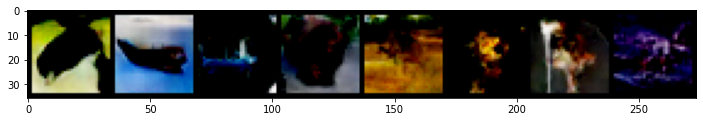

epoch: 281, batch: 100	   lossD: 0.1465(real: 0.0181, fake: 0.1284), lossG: 4.0821,  D(x): 0.9826, D(G(z)): 0.1058, 0.0561
epoch: 281, batch: 200	   lossD: 0.1781(real: 0.1259, fake: 0.0523), lossG: 3.1147,  D(x): 0.8929, D(G(z)): 0.0436, 0.1727
epoch: 281, batch: 300	   lossD: 0.2062(real: 0.1004, fake: 0.1058), lossG: 4.8776,  D(x): 0.9139, D(G(z)): 0.0904, 0.0343
epoch: 281, batch: 400	   lossD: 0.1615(real: 0.0370, fake: 0.1246), lossG: 4.9300,  D(x): 0.9654, D(G(z)): 0.1073, 0.0286
epoch: 281, batch: 500	   lossD: 0.3395(real: 0.0301, fake: 0.3094), lossG: 4.5447,  D(x): 0.9715, D(G(z)): 0.2053, 0.0367
epoch: 281, running_loss_D: 0.2917940616607666, running_loss_G: 3.7612855434417725 

epoch: 282, batch: 100	   lossD: 0.2857(real: 0.2415, fake: 0.0442), lossG: 2.8933,  D(x): 0.8148, D(G(z)): 0.0409, 0.1498
epoch: 282, batch: 200	   lossD: 0.3015(real: 0.2469, fake: 0.0546), lossG: 3.5157,  D(x): 0.8256, D(G(z)): 0.0485, 0.1068
epoch: 282, batch: 300	   lossD: 0.5416(real: 0.5037, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 300, batch: 500	   lossD: 0.1928(real: 0.0483, fake: 0.1445), lossG: 3.6202,  D(x): 0.9563, D(G(z)): 0.1103, 0.0981
epoch: 300, running_loss_D: 0.2550610601902008, running_loss_G: 3.832801342010498 



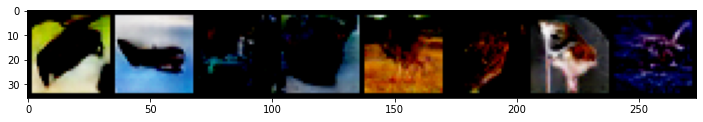

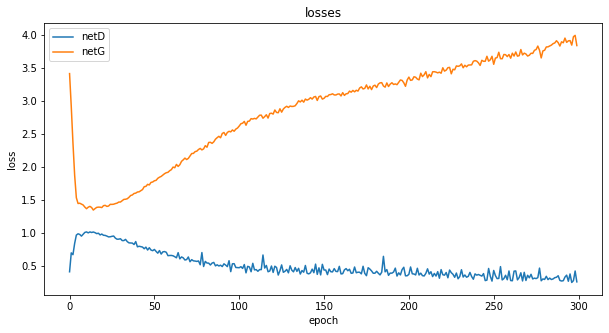

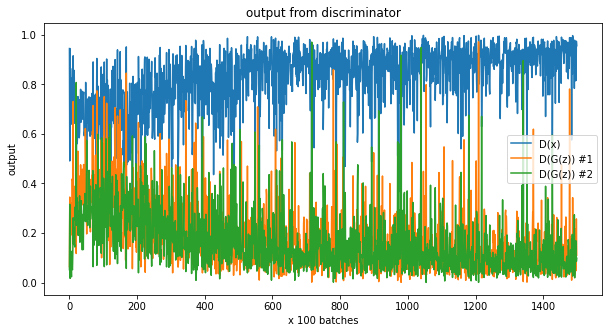

epoch: 301, batch: 100	   lossD: 0.1328(real: 0.0773, fake: 0.0554), lossG: 3.6901,  D(x): 0.9341, D(G(z)): 0.0492, 0.0933
epoch: 301, batch: 200	   lossD: 0.2998(real: 0.2420, fake: 0.0578), lossG: 2.5093,  D(x): 0.8120, D(G(z)): 0.0494, 0.1861
epoch: 301, batch: 300	   lossD: 0.1729(real: 0.0265, fake: 0.1463), lossG: 3.4974,  D(x): 0.9748, D(G(z)): 0.1198, 0.1115
epoch: 301, batch: 400	   lossD: 0.2140(real: 0.1933, fake: 0.0207), lossG: 4.5138,  D(x): 0.8562, D(G(z)): 0.0191, 0.0582
epoch: 301, batch: 500	   lossD: 0.3467(real: 0.0207, fake: 0.3261), lossG: 4.0806,  D(x): 0.9799, D(G(z)): 0.2084, 0.0485
epoch: 301, running_loss_D: 0.25515007972717285, running_loss_G: 3.946415901184082 

epoch: 302, batch: 100	   lossD: 0.1856(real: 0.1241, fake: 0.0615), lossG: 3.8469,  D(x): 0.8998, D(G(z)): 0.0489, 0.0742
epoch: 302, batch: 200	   lossD: 0.1559(real: 0.1002, fake: 0.0558), lossG: 3.1470,  D(x): 0.9163, D(G(z)): 0.0482, 0.1431
epoch: 302, batch: 300	   lossD: 0.2166(real: 0.1869, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 320, batch: 500	   lossD: 0.1874(real: 0.0681, fake: 0.1193), lossG: 6.0459,  D(x): 0.9389, D(G(z)): 0.0994, 0.0086
epoch: 320, running_loss_D: 0.41959530115127563, running_loss_G: 3.970958709716797 



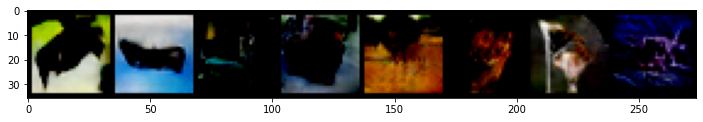

epoch: 321, batch: 100	   lossD: 0.1305(real: 0.0438, fake: 0.0866), lossG: 4.3238,  D(x): 0.9587, D(G(z)): 0.0733, 0.0421
epoch: 321, batch: 200	   lossD: 0.1755(real: 0.0725, fake: 0.1030), lossG: 3.3741,  D(x): 0.9379, D(G(z)): 0.0722, 0.1001
epoch: 321, batch: 300	   lossD: 0.1377(real: 0.0434, fake: 0.0944), lossG: 4.5542,  D(x): 0.9611, D(G(z)): 0.0799, 0.0405
epoch: 321, batch: 400	   lossD: 0.1822(real: 0.0817, fake: 0.1005), lossG: 3.5136,  D(x): 0.9286, D(G(z)): 0.0834, 0.1336
epoch: 321, batch: 500	   lossD: 0.0995(real: 0.0414, fake: 0.0581), lossG: 2.2308,  D(x): 0.9626, D(G(z)): 0.0534, 0.2662
epoch: 321, running_loss_D: 0.22342555224895477, running_loss_G: 4.0145392417907715 

epoch: 322, batch: 100	   lossD: 0.2862(real: 0.2460, fake: 0.0402), lossG: 3.2595,  D(x): 0.8279, D(G(z)): 0.0376, 0.1451
epoch: 322, batch: 200	   lossD: 0.4951(real: 0.4553, fake: 0.0398), lossG: 1.6855,  D(x): 0.7126, D(G(z)): 0.0330, 0.3565
epoch: 322, batch: 300	   lossD: 0.3996(real: 0.3650,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 340, batch: 500	   lossD: 0.4647(real: 0.0242, fake: 0.4405), lossG: 5.6838,  D(x): 0.9769, D(G(z)): 0.2748, 0.0121
epoch: 340, running_loss_D: 0.3627493679523468, running_loss_G: 4.172006607055664 



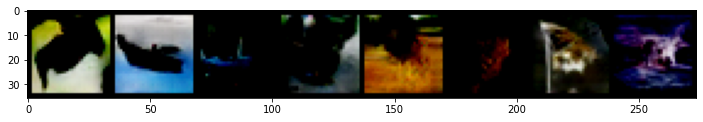

epoch: 341, batch: 100	   lossD: 0.2229(real: 0.1597, fake: 0.0632), lossG: 4.0051,  D(x): 0.8709, D(G(z)): 0.0465, 0.0644
epoch: 341, batch: 200	   lossD: 0.2194(real: 0.0544, fake: 0.1649), lossG: 4.2768,  D(x): 0.9514, D(G(z)): 0.1177, 0.0613
epoch: 341, batch: 300	   lossD: 0.1522(real: 0.1069, fake: 0.0453), lossG: 3.1589,  D(x): 0.9087, D(G(z)): 0.0408, 0.1611
epoch: 341, batch: 400	   lossD: 0.2655(real: 0.1120, fake: 0.1535), lossG: 3.8961,  D(x): 0.9161, D(G(z)): 0.1127, 0.0623
epoch: 341, batch: 500	   lossD: 0.2615(real: 0.1634, fake: 0.0981), lossG: 3.6832,  D(x): 0.8739, D(G(z)): 0.0787, 0.0931
epoch: 341, running_loss_D: 0.3107769787311554, running_loss_G: 3.969303846359253 

epoch: 342, batch: 100	   lossD: 0.2324(real: 0.1996, fake: 0.0328), lossG: 3.3846,  D(x): 0.8431, D(G(z)): 0.0309, 0.0981
epoch: 342, batch: 200	   lossD: 0.3642(real: 0.3318, fake: 0.0324), lossG: 5.0578,  D(x): 0.7564, D(G(z)): 0.0291, 0.0426
epoch: 342, batch: 300	   lossD: 0.2606(real: 0.0569, f

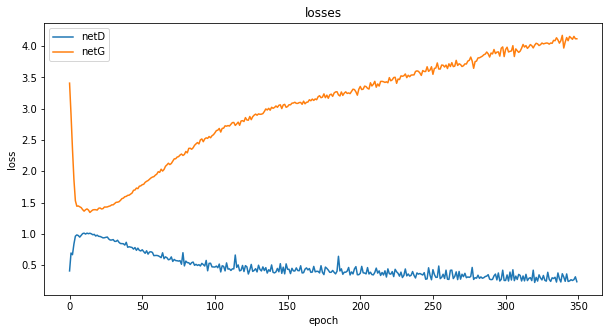

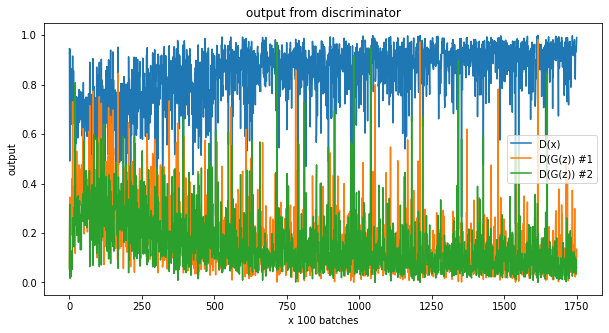

epoch: 351, batch: 100	   lossD: 0.2019(real: 0.1273, fake: 0.0746), lossG: 4.7904,  D(x): 0.8938, D(G(z)): 0.0568, 0.0431
epoch: 351, batch: 200	   lossD: 0.3221(real: 0.2397, fake: 0.0825), lossG: 2.8171,  D(x): 0.8240, D(G(z)): 0.0681, 0.1913
epoch: 351, batch: 300	   lossD: 0.2428(real: 0.2026, fake: 0.0402), lossG: 4.2085,  D(x): 0.8367, D(G(z)): 0.0264, 0.0672
epoch: 351, batch: 400	   lossD: 0.1289(real: 0.0196, fake: 0.1092), lossG: 4.8617,  D(x): 0.9810, D(G(z)): 0.0834, 0.0368
epoch: 351, batch: 500	   lossD: 0.1904(real: 0.1169, fake: 0.0735), lossG: 4.0763,  D(x): 0.9027, D(G(z)): 0.0642, 0.0793
epoch: 351, running_loss_D: 0.37094274163246155, running_loss_G: 4.178013324737549 

epoch: 352, batch: 100	   lossD: 0.3097(real: 0.2007, fake: 0.1090), lossG: 4.0164,  D(x): 0.8461, D(G(z)): 0.0828, 0.0620
epoch: 352, batch: 200	   lossD: 0.1697(real: 0.0914, fake: 0.0783), lossG: 5.2012,  D(x): 0.9238, D(G(z)): 0.0586, 0.0235
epoch: 352, batch: 300	   lossD: 0.1535(real: 0.0831, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 360, batch: 500	   lossD: 0.1937(real: 0.0421, fake: 0.1516), lossG: 3.9771,  D(x): 0.9606, D(G(z)): 0.1229, 0.0513
epoch: 360, running_loss_D: 0.3573528826236725, running_loss_G: 4.186193466186523 



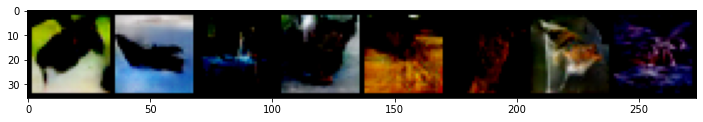

epoch: 361, batch: 100	   lossD: 0.1566(real: 0.0757, fake: 0.0809), lossG: 3.5561,  D(x): 0.9315, D(G(z)): 0.0674, 0.0916
epoch: 361, batch: 200	   lossD: 0.0872(real: 0.0315, fake: 0.0557), lossG: 3.6842,  D(x): 0.9701, D(G(z)): 0.0468, 0.0891
epoch: 361, batch: 300	   lossD: 0.1336(real: 0.0938, fake: 0.0398), lossG: 4.9378,  D(x): 0.9251, D(G(z)): 0.0360, 0.0383
epoch: 361, batch: 400	   lossD: 0.1499(real: 0.0866, fake: 0.0634), lossG: 3.6800,  D(x): 0.9317, D(G(z)): 0.0531, 0.0861
epoch: 361, batch: 500	   lossD: 0.1650(real: 0.0218, fake: 0.1432), lossG: 4.8671,  D(x): 0.9798, D(G(z)): 0.1027, 0.0363
epoch: 361, running_loss_D: 0.2132679522037506, running_loss_G: 4.218564510345459 

epoch: 362, batch: 100	   lossD: 0.1776(real: 0.0577, fake: 0.1200), lossG: 5.3995,  D(x): 0.9465, D(G(z)): 0.1012, 0.0271
epoch: 362, batch: 200	   lossD: 0.2070(real: 0.0204, fake: 0.1866), lossG: 4.4142,  D(x): 0.9802, D(G(z)): 0.1464, 0.0440
epoch: 362, batch: 300	   lossD: 0.1765(real: 0.0339, f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 380, batch: 500	   lossD: 3.5952(real: 0.0001, fake: 3.5951), lossG: 10.1292,  D(x): 0.9999, D(G(z)): 0.8740, 0.0013
epoch: 380, running_loss_D: 0.2537001073360443, running_loss_G: 4.352521896362305 



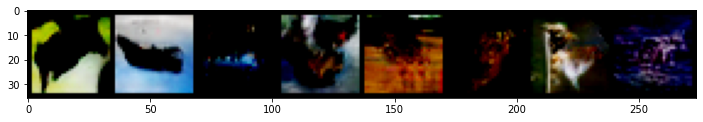

epoch: 381, batch: 100	   lossD: 0.3020(real: 0.2065, fake: 0.0956), lossG: 4.3560,  D(x): 0.8351, D(G(z)): 0.0819, 0.0482
epoch: 381, batch: 200	   lossD: 0.2045(real: 0.0712, fake: 0.1334), lossG: 3.9812,  D(x): 0.9375, D(G(z)): 0.0932, 0.0836
epoch: 381, batch: 300	   lossD: 0.3204(real: 0.3090, fake: 0.0114), lossG: 2.8739,  D(x): 0.7680, D(G(z)): 0.0112, 0.1949
epoch: 381, batch: 400	   lossD: 0.2437(real: 0.1045, fake: 0.1392), lossG: 4.3881,  D(x): 0.9143, D(G(z)): 0.1083, 0.0537
epoch: 381, batch: 500	   lossD: 0.1502(real: 0.0442, fake: 0.1060), lossG: 3.8829,  D(x): 0.9598, D(G(z)): 0.0863, 0.0778
epoch: 381, running_loss_D: 0.2753697633743286, running_loss_G: 4.230197429656982 

epoch: 382, batch: 100	   lossD: 0.3709(real: 0.0182, fake: 0.3527), lossG: 4.4742,  D(x): 0.9828, D(G(z)): 0.2359, 0.0631
epoch: 382, batch: 200	   lossD: 0.2083(real: 0.0292, fake: 0.1791), lossG: 4.3900,  D(x): 0.9721, D(G(z)): 0.1231, 0.0491
epoch: 382, batch: 300	   lossD: 0.1760(real: 0.1254, f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 400, batch: 500	   lossD: 0.1617(real: 0.0249, fake: 0.1369), lossG: 3.0216,  D(x): 0.9771, D(G(z)): 0.0925, 0.1460
epoch: 400, running_loss_D: 0.2317316234111786, running_loss_G: 4.346471309661865 



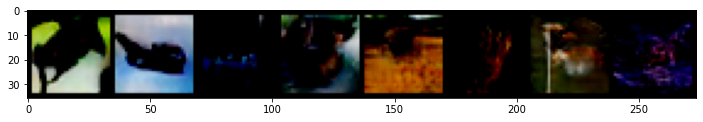

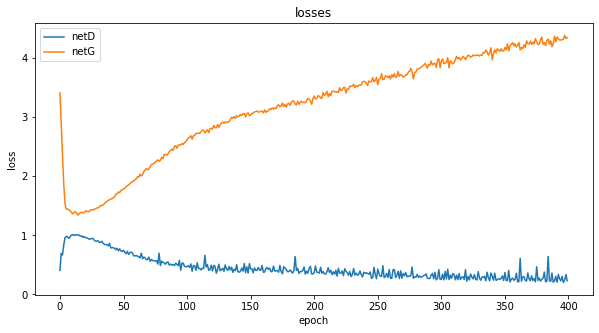

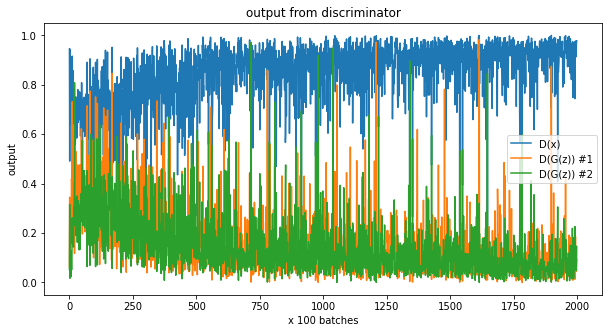

epoch: 401, batch: 100	   lossD: 0.2881(real: 0.1864, fake: 0.1017), lossG: 3.5105,  D(x): 0.8504, D(G(z)): 0.0815, 0.1084
epoch: 401, batch: 200	   lossD: 0.0576(real: 0.0138, fake: 0.0438), lossG: 4.9035,  D(x): 0.9868, D(G(z)): 0.0388, 0.0337
epoch: 401, batch: 300	   lossD: 0.2294(real: 0.1622, fake: 0.0672), lossG: 4.6319,  D(x): 0.8743, D(G(z)): 0.0543, 0.0554
epoch: 401, batch: 400	   lossD: 0.1061(real: 0.0669, fake: 0.0392), lossG: 4.3682,  D(x): 0.9393, D(G(z)): 0.0311, 0.0498
epoch: 401, batch: 500	   lossD: 0.1068(real: 0.0714, fake: 0.0355), lossG: 4.3947,  D(x): 0.9427, D(G(z)): 0.0328, 0.0495
epoch: 401, running_loss_D: 0.3653813302516937, running_loss_G: 4.39923095703125 

epoch: 402, batch: 100	   lossD: 0.2045(real: 0.1098, fake: 0.0947), lossG: 4.5852,  D(x): 0.9032, D(G(z)): 0.0622, 0.0436
epoch: 402, batch: 200	   lossD: 0.2642(real: 0.1374, fake: 0.1268), lossG: 3.9201,  D(x): 0.8990, D(G(z)): 0.0991, 0.0693
epoch: 402, batch: 300	   lossD: 0.1354(real: 0.1203, fa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 420, batch: 500	   lossD: 1.6842(real: 0.0393, fake: 1.6450), lossG: 7.5004,  D(x): 0.9680, D(G(z)): 0.5923, 0.0058
epoch: 420, running_loss_D: 0.3075595498085022, running_loss_G: 4.5235819816589355 



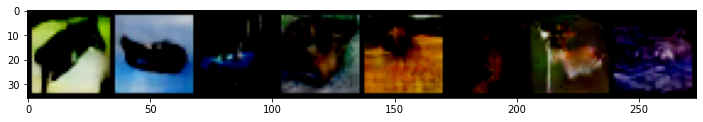

epoch: 421, batch: 100	   lossD: 0.1667(real: 0.0239, fake: 0.1428), lossG: 3.2330,  D(x): 0.9775, D(G(z)): 0.0958, 0.1785
epoch: 421, batch: 200	   lossD: 0.1614(real: 0.1158, fake: 0.0456), lossG: 4.5692,  D(x): 0.9056, D(G(z)): 0.0393, 0.0400
epoch: 421, batch: 300	   lossD: 0.5413(real: 0.5109, fake: 0.0304), lossG: 2.5986,  D(x): 0.6931, D(G(z)): 0.0241, 0.2272
epoch: 421, batch: 400	   lossD: 0.1905(real: 0.0771, fake: 0.1134), lossG: 5.4606,  D(x): 0.9347, D(G(z)): 0.0828, 0.0276
epoch: 421, batch: 500	   lossD: 0.1179(real: 0.0458, fake: 0.0721), lossG: 4.4465,  D(x): 0.9602, D(G(z)): 0.0459, 0.0420
epoch: 421, running_loss_D: 0.23752117156982422, running_loss_G: 4.324745178222656 

epoch: 422, batch: 100	   lossD: 0.0656(real: 0.0402, fake: 0.0254), lossG: 4.4111,  D(x): 0.9630, D(G(z)): 0.0235, 0.0530
epoch: 422, batch: 200	   lossD: 0.3693(real: 0.0095, fake: 0.3597), lossG: 3.9036,  D(x): 0.9907, D(G(z)): 0.2093, 0.0924
epoch: 422, batch: 300	   lossD: 0.1297(real: 0.0967, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 440, batch: 500	   lossD: 0.1425(real: 0.0787, fake: 0.0638), lossG: 5.7696,  D(x): 0.9295, D(G(z)): 0.0466, 0.0222
epoch: 440, running_loss_D: 0.21759220957756042, running_loss_G: 4.623932361602783 



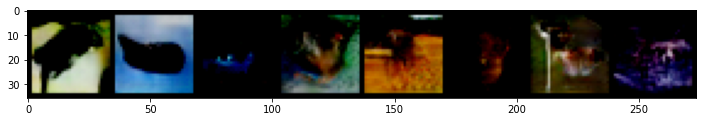

epoch: 441, batch: 100	   lossD: 0.1713(real: 0.1017, fake: 0.0695), lossG: 5.0744,  D(x): 0.9156, D(G(z)): 0.0582, 0.0300
epoch: 441, batch: 200	   lossD: 0.2117(real: 0.1773, fake: 0.0344), lossG: 4.0945,  D(x): 0.8581, D(G(z)): 0.0325, 0.0596
epoch: 441, batch: 300	   lossD: 0.1729(real: 0.1617, fake: 0.0112), lossG: 4.2171,  D(x): 0.8644, D(G(z)): 0.0109, 0.0783
epoch: 441, batch: 400	   lossD: 0.3017(real: 0.0054, fake: 0.2963), lossG: 5.1082,  D(x): 0.9947, D(G(z)): 0.2038, 0.0318
epoch: 441, batch: 500	   lossD: 0.2137(real: 0.1873, fake: 0.0264), lossG: 6.0415,  D(x): 0.8720, D(G(z)): 0.0227, 0.0228
epoch: 441, running_loss_D: 0.20962445437908173, running_loss_G: 4.613742828369141 

epoch: 442, batch: 100	   lossD: 0.1068(real: 0.0213, fake: 0.0855), lossG: 4.3301,  D(x): 0.9794, D(G(z)): 0.0690, 0.0595
epoch: 442, batch: 200	   lossD: 0.0756(real: 0.0311, fake: 0.0444), lossG: 4.2380,  D(x): 0.9702, D(G(z)): 0.0390, 0.0751
epoch: 442, batch: 300	   lossD: 0.3164(real: 0.3084, 

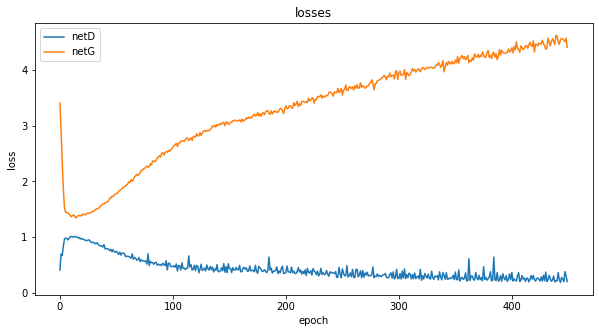

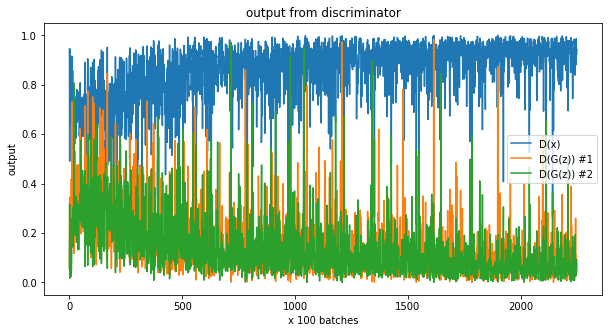

epoch: 451, batch: 100	   lossD: 0.1149(real: 0.0978, fake: 0.0172), lossG: 5.9481,  D(x): 0.9182, D(G(z)): 0.0167, 0.0226


In [ ]:
EPOCHS = 600 #学習の回数を変更してどれだけ綺麗になるかを出してみよう
losses, outs, nets= train(netD, netG, batch_size, zsize, EPOCHS, trainloader)

In [ ]:
plt.figure(figsize=(10,5))
plt.title('losses')
plt.plot(losses[0], label='netD')
plt.plot(losses[1], label='netG')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('1821035_losses.jpg')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title('output from discriminator')
plt.plot(outs[0], label='D(x)')
plt.plot(outs[1], label='D(G(z)) #1')
plt.plot(outs[2], label='D(G(z)) #2')
plt.xlabel('x 100 batches')
plt.ylabel('output')
plt.legend()
plt.savefig('1821035_output.jpg')
plt.show()

# 宿題




## 【1】綺麗な画像を生成して１番良さそうなのを提出してください
この事例研究の時間だけまわしておしまいなのは勿体ないです。なのでぜひ皆さんの自身の手を動かしてどのように結果が変化するのか確認しましょう！

生成した画像とlossの画像を下記のディレクトリへ金曜日までにアップロードしといてください。\
**＜提出場所＞**
```bash:
共有ドライブ/IPL Drive/05_講義資料/事例研究2020/08_20201208/課題提出箱/gxxxxxx
```
gxxxxxxには自分の学籍番号です。既に作成してあるので、そこにアップロードしてください。




## 【2】今日の話で大切だと思ったプログラムにコメントを入れる
　コメントは**ソースコードの保守をする人に情報を伝えるため**に記述します。なお、この保守する人には未来の自分も含まれます。

　いくら自分が書いたソースコードとはいえ、半年も経てば細かい仕様等は忘れていきます。なので、未来の自分や他の人がこのソースを使いたいとき、コメントがあることによって彼らの作業時間の短縮ができます。今回はその練習としてコメント入れる作業の練習をしましょう。


コメントとして記述するもの
- 実装概念との対応関係
    - 今回であれば、`GANのGeneratorはこの部分で定義されている`等
- 引数の説明
    - 特に直打ちしている値は、**その値が何なのか**がわかるようなコメントを記述しましょう

最初のセル2つは佐藤がコメントアウトで入れています。\
伝わるように書けばいいのでコメントの書き方は自由なので工夫してください。



# 変更点
#### バッチノーマライゼーションを追記
- 学習効率の向上、過学習の抑制、初期値に対しての依存度を低下させるため。

#### 重みを独自に初期化
- 初期値はニューラルネットワークの学習速度に影響を及ぼす。さらに、適切な初期値を設定しないと「勾配消失」、「表現力の制限」といった問題も引き起こす。
今回は、平均0、標準偏差0.02に設定した。
  